## 1. Setup and Dependencies

<div style="background-color: #e8f8f0; padding: 15px; border-left: 5px solid #27ae60; border-radius: 8px; 
box-shadow: 0 4px 6px rgba(0,0,0,0.05); font-family: Arial, sans-serif; color: #34495e; font-size: 16px; max-width: 100%; width: 100%; word-wrap: break-word; box-sizing: border-box;">

  <h2 style="color: #2c3e50;">Environment Setup</h2>

  <p style="font-size: 14px; color: #34495e;">
    Install required libraries and set up the environment for quantum and classical simulations.
  </p>

</div>

In [4]:
import http.server, socketserver, threading, numpy as np, matplotlib.pyplot as plt, time
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.visualization import plot_histogram
from scipy.stats import binom, norm
import matplotlib.pyplot as plt
from qiskit.transpiler import InstructionDurations, PassManager
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling
from qiskit.circuit.library import XGate,YGate
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Styling for plots
plt.style.use('seaborn-v0_8') 

## 2. Introduction 

<div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.1); font-family: Arial, sans-serif; color: #34495e; font-size: 16px; max-width: 100%; width: 100%; overflow-wrap: break-word; word-break: break-word; box-sizing: border-box">

  <h2 style="color: #2c3e50; font-size: 22px;">Quantum Galton Board (3-layer) (Ideal case)</h2>
  <p> Since the hardware supports a maximum of 10 qubits, we implemented a 3‑layer Galton board circuit for noise simulation, as it requires 8 qubits. 
  
  In practice, not all 10 qubits are available for use due to potential hardware defects, making the 3‑layer configuration a practical choice to run it on hardawre.
  </p>
  </div>

In [6]:
# For 3 layers 
layers = 3
n_qubits = 7 + 1
n_bits = 4
bins = layers + 1

ancilla = 0
ball = layers + 1

state_0 = [1,0]

peg_circuit = QuantumCircuit(n_qubits,n_bits)

# set up 
peg_circuit.h(ancilla)
peg_circuit.x(ball)

# first layer
peg_circuit.cswap(0,ball-1,ball)
peg_circuit.cx(ball,0)
peg_circuit.cswap(0,ball,ball + 1)

# second layer
peg_circuit.initialize(state_0,ancilla)
peg_circuit.h(ancilla)

for i in range(3):
    base = ball - 1 + i
    peg_circuit.cswap(0,base-1,base)
    peg_circuit.cx(base,0)

base += 1
peg_circuit.cswap(0,base-1,base)

# third layer
peg_circuit.initialize(state_0,ancilla)
peg_circuit.h(ancilla)


for i in range(5):
    base = ball - 2 + i
    peg_circuit.cswap(ancilla, base - 1, base)
    peg_circuit.cx(base,ancilla)

base += 1
peg_circuit.cswap(0,base-1,base)

for i in range(bins):
    peg_circuit.measure((2*i + 1), i)

peg_circuit.draw()

┌───┐   ┌───┐   ┌─────────────────┐┌───┐   ┌───┐   ┌───┐   ┌───┐   »
q_0: ┤ H ├─■─┤ X ├─■─┤ Initialize(1,0) ├┤ H ├─■─┤ X ├─■─┤ X ├─■─┤ X ├─■─»
     └───┘ │ └─┬─┘ │ └─────────────────┘└───┘ │ └─┬─┘ │ └─┬─┘ │ └─┬─┘ │ »
q_1: ──────┼───┼───┼──────────────────────────┼───┼───┼───┼───┼───┼───┼─»
           │   │   │                          │   │   │   │   │   │   │ »
q_2: ──────┼───┼───┼──────────────────────────X───┼───┼───┼───┼───┼───┼─»
           │   │   │                          │   │   │   │   │   │   │ »
q_3: ──────X───┼───┼──────────────────────────X───■───X───┼───┼───┼───┼─»
     ┌───┐ │   │   │                                  │   │   │   │   │ »
q_4: ┤ X ├─X───■───X──────────────────────────────────X───■───X───┼───┼─»
     └───┘         │                                          │   │   │ »
q_5: ──────────────X──────────────────────────────────────────X───■───X─»
                                                                      │ »
q_6: ─────────────────────────────────────────────────────────────────X─»
                                                                        »
q_7: ───────────────────────────────────────────────────────────────────»
                                                                        »
c: 4/═══════════════════════════════════════════════════════════════════»
                                                                        »
«     ┌─────────────────┐┌───┐   ┌───┐      ┌───┐   ┌───┐      ┌───┐   ┌───┐   »
«q_0: ┤ Initialize(1,0) ├┤ H ├─■─┤ X ├────■─┤ X ├─■─┤ X ├────■─┤ X ├─■─┤ X ├───»
«     └─────────────────┘└───┘ │ └─┬─┘┌─┐ │ └─┬─┘ │ └─┬─┘    │ └─┬─┘ │ └─┬─┘   »
«q_1: ─────────────────────────X───┼──┤M├─┼───┼───┼───┼──────┼───┼───┼───┼─────»
«                              │   │  └╥┘ │   │   │   │      │   │   │   │     »
«q_2: ─────────────────────────X───■───╫──X───┼───┼───┼──────┼───┼───┼───┼─────»
«                                      ║  │   │   │   │  ┌─┐ │   │   │   │     »
«q_3: ─────────────────────────────────╫──X───■───X───┼──┤M├─┼───┼───┼───┼─────»
«                                      ║          │   │  └╥┘ │   │   │   │     »
«q_4: ─────────────────────────────────╫──────────X───■───╫──X───┼───┼───┼─────»
«                                      ║                  ║  │   │   │   │  ┌─┐»
«q_5: ─────────────────────────────────╫──────────────────╫──X───■───X───┼──┤M├»
«                                      ║                  ║          │   │  └╥┘»
«q_6: ─────────────────────────────────╫──────────────────╫──────────X───■───╫─»
«                                      ║                  ║                  ║ »
«q_7: ─────────────────────────────────╫──────────────────╫──────────────────╫─»
«                                      ║                  ║                  ║ »
«c: 4/═════════════════════════════════╩══════════════════╩══════════════════╩═»
«                                      0                  1                  2 »
«           
«q_0: ─■────
«      │    
«q_1: ─┼────
«      │    
«q_2: ─┼────
«      │    
«q_3: ─┼────
«      │    
«q_4: ─┼────
«      │    
«q_5: ─┼────
«      │    
«q_6: ─X────
«      │ ┌─┐
«q_7: ─X─┤M├
«        └╥┘
«c: 4/════╩═
«         3

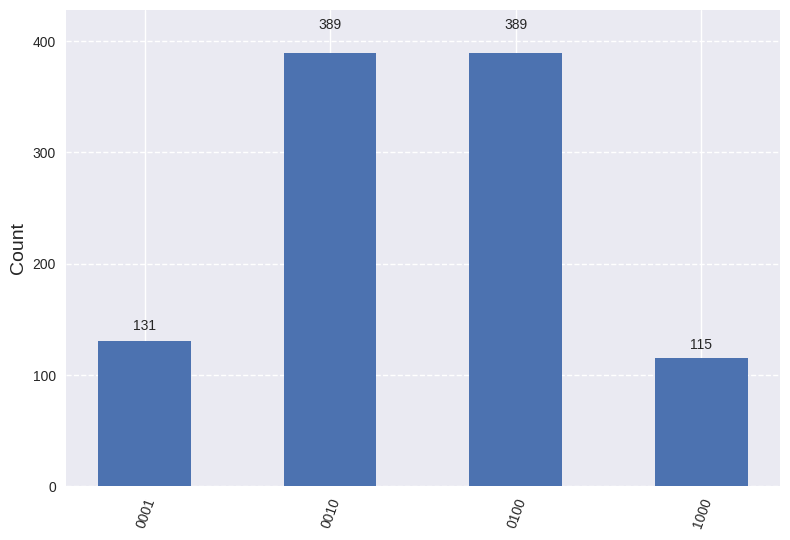

In [7]:
aer_sim = AerSimulator().run(peg_circuit,shots=1024)
answer = aer_sim.result().get_counts(peg_circuit)
plot_histogram(answer)

## 3. Noise Mitigation

<div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.1); font-family: Arial, sans-serif; color: #34495e; font-size: 16px; max-width: 100%; width: 100%; overflow-wrap: break-word; word-break: break-word; box-sizing: border-box">

  <h2 style="color: #2c3e50; font-size: 22px;">Quantum Galton Board (3-layer) with Noise</h2>
  <p> 
  We used four ways to figure out which method gives us the least error probabilty , considering circuit depth and hardware limitations.

   <ul style="font-size: 14px;">
   <li> Noise Mitigation using transpiler </li>
   <li> Noise Mitigation using PaddynamicalDecoupling </li>
   <li> Noise Mitigation using Error readout mitigation </li>
   <li> Noise Mitigation using PaddynamicalDecoupling & Error readout mitigation </li>
   
   </ul>

  </p>

  ---

  <section id ="Looping">
  <h3> Looping structure </h3>
  <p id ="Looping Structure">
  The approach used to analyze error and calculate probability within the quantum simulation for all the different cases of noise mitigation models is as follows:

  <ul style="font-size: 14px;">
  <li>Loop structure - We iterated over 

  <ul style="font-size: 14px;">
  <li>state which represents the quantum state of the measurement outcome </li> 
  <li> count - which is the number of times state was observed in the simulation (simulated over 100,000 times) </li>
  </ul>
  </li>

   <li>The condition checks if the state contains exactly one '1'(i.e only one qubit was measured as '1'), which implies a valid single detection event : 
   
  <ul style="font-size: 14px;">
  <li> True condition:

   <ul style="font-size: 14px;">
   <li>The state string is reversed to align with the indexing convention used for bin assignment </li>
   <li>The index of the '1' in the reversed state determines which bin (0 to 3) the outcome belongs to, and accordingly the probability of the outcome is evaluated </li>
   </ul>
   </li>

   <li> False Condition:

   <ul style="font-size: 14px;">
   <li> If the state contains zero's or multiple 1's then it is classified as an error, hence error probability is accordingly calculated  </li>
   </ul>
   </li>

   </li>
</ul>

   <li>The loop assigns probabilities to specific bins based on the position of a single '1' in the measurement outcome. </li>
   </ul>
  </p>
  </section>
  
  ---

## 3.1 Noise Simulation

<div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.1); font-family: Arial, sans-serif; color: #34495e; font-size: 16px; max-width: 100%; width: 100%; overflow-wrap: break-word; word-break: break-word; box-sizing: border-box">

  <h2 style="color: #2c3e50; font-size: 22px;"> Using transpiler</h2>

  The strategy focuses on realistic noise modeling to simulate errors, multi-shot statistical sampling for robustness, and classical post-processing to categorize valid vs. erroneous outcomes, enabling error rate evaluation without active mitigation.
  <p> 

  We made the following changes:

  <ol style="font-size: 14px;">
  <li> <b> Circuit Construction</b>: It is the same as the ideal Circuit setup. </li>

  <li> <b> Noise Integration and Simulation </b>: A NoiseModel is derived from the IBM Torin backend properties (T1/T2, frequencies, gate errors). The AerSimulator incorporates this noise, and the circuit is transpiled with optimization level 2 for backend compatibility, then executed with 10,000 shots to generate noisy counts.</li>

  <li> <b> Error Quantification via Post-Processing</b>: The simulation runs with 10,000 shots, and the resulting counts are evaluating following the looping structure described in Section <a href="#Looping"> (2) </a> </li> 

  </ol>
  This approach highlights noise impacts in the layered circuit while keeping computation efficient.
  </p> 
  </div>

Bin probabilities (bins 0 to 3): [0.09526, 0.28605, 0.256, 0.08705]
Error probability: 0.27564
Sum of bin probabilities: 0.72436


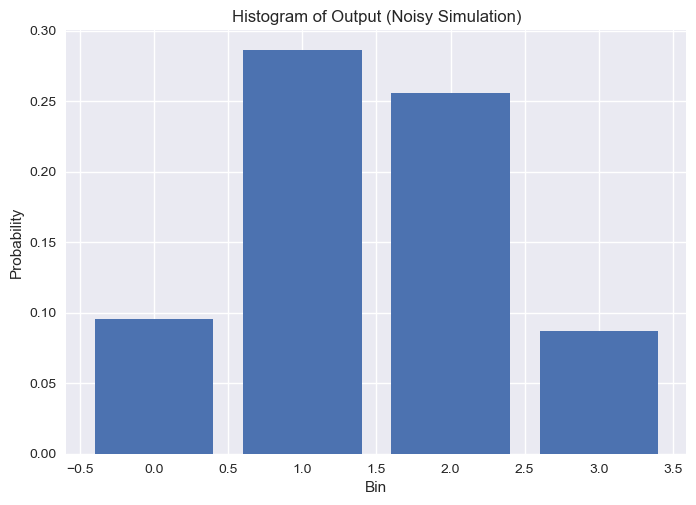

In [ ]:
layers1 = 3
n_qubits = 7 + 1
n_bits = 4
bins1 = layers1 + 1
ancilla1 = 0
ball1 = layers1 + 1
state_0 = [1, 0]

pegn_circuit = QuantumCircuit(n_qubits, n_bits)

# Setup
pegn_circuit.h(ancilla1)
pegn_circuit.x(ball1)

# First layer
pegn_circuit.cswap(0, ball1 - 1, ball1)
pegn_circuit.cx(ball1, 0)
pegn_circuit.cswap(0, ball1, ball1 + 1)

# Second layer
pegn_circuit.initialize(state_0, ancilla1)
pegn_circuit.h(ancilla1)
for i in range(3):
    base1 = ball1 - 1 + i
    pegn_circuit.cswap(0, base1 - 1, base1)
    pegn_circuit.cx(base1, 0)
base1 += 1
pegn_circuit.cswap(0, base1 - 1, base1)

# Third layer
pegn_circuit.initialize(state_0, ancilla1)
pegn_circuit.h(ancilla1)
for i in range(5):
    base1 = ball1 - 2 + i
    pegn_circuit.cswap(ancilla1, base1 - 1, base1)
    pegn_circuit.cx(base1, ancilla1)
base1 += 1
pegn_circuit.cswap(0, base1 - 1, base1)


for i in range(bins1):
    pegn_circuit.measure((2 * i + 1), i)

QiskitRuntimeService.save_account(channel="ibm_quantum_platform",token="7N3mbyY33yxRsQ3uwQvs904tUcfY5hdM0R5wWlNRlgLB", overwrite=True)
service1 = QiskitRuntimeService(channel="ibm_quantum_platform", instance ="crn:v1:bluemix:public:quantum-computing:us-east:a/c7e62e1fb1fb4925b728838713b6aa25:6e4a7739-ec20-4abb-a8c4-f6632a04f502::")

backendpeg = service1.backend('ibm_torino')

# Creating noise model from the backend properties (pulls live T1, T2, frequencies, gate errors, etc.)
noise_modelpeg = NoiseModel.from_backend(backendpeg)

# Setting up noisy simulator
simulatorpeg = AerSimulator(noise_model=noise_modelpeg)

# Transpile the circuit with optimization (level 2)
transpiled_qc1 = transpile(pegn_circuit, backend=backendpeg, optimization_level=2)

# Run the simulation
shotspeg = 100000
resultpeg = simulatorpeg.run(transpiled_qc1, shots=shotspeg).result()
countspeg = resultpeg.get_counts()


# Process counts to compute bin probabilities
# Assuming ideal outcomes are one-hot on measured qubits (1,3,5,7) → bins 0-3; others as errors
bin1_probs1 = [0.0] * 4
error1_prob1 = 0.0

for state, count in countspeg.items():
    if state.count('1') == 1:  # Valid single-detection
        reversed_state1 = state[::-1]
        bin1_index = reversed_state1.index('1')
        bin1_probs1[bin1_index] += count / shotspeg
    else:
        error1_prob1 += count / shotspeg


print("Bin probabilities (bins 0 to 3):", bin1_probs1)
print("Error probability:", error1_prob1)
print("Sum of bin probabilities:", sum(bin1_probs1))
plt.bar(range(4), bin1_probs1)
plt.xlabel('Bin')
plt.ylabel('Probability')
plt.title('Histogram of Output (Noisy Simulation)')
plt.show()

In [50]:
# circuit output of how transpiler converted into basic gateset
transpiled_qc.draw(output='mpl');

## 3.2 Error Suppression using DynamicalDecoupling

<div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.1); font-family: Arial, sans-serif; color: #34495e; font-size: 16px; max-width: 100%; width: 100%; overflow-wrap: break-word; word-break: break-word; box-sizing: border-box">

  <h2 style="color: #2c3e50; font-size: 22px;"> Using DynamicalDecoupling</h2>

This strategy focuses on mitigating dephasing errors through dynamical decoupling.

  <p> 

  <ul style="font-size: 14px;">

  <li> <b>Circuit Setup and Noise Modeling </b>: After setting up the circuit,we have incorporated noise properties from the IBM Torin backend via a NoiseModel.   </li>

  <li> <b>Dynamical Decoupling </b>: The circuit is transpiled with optimization (level 2) and enhanced using ALAPScheduleAnalysis with an XX sequence (XGate, XGate) for dephasing suppression, applied via PaddyDynamicalDecoupling.
  
  <ul style="font-size: 14px;">

  <li>ALAPScheduleAnalysis is a transpiler pass in Qiskit that schedules quantum circuit instructions "as late as possible" (ALAP) while respecting hardware constraints, such as gate durations and alignment requirements. This pass is invoked prior to DD insertion to- 
  
  <ul style="font-size: 14px;">

  <li> <b> Input Handling </b>: The pass uses the durations parameter to inform the scheduling process, determining the execution times of gates and operations on the target backend. No explicit "ALAP" scheduling method is passed as an additional instruction; instead, the class inherently performs as-late-as-possible (ALAP) scheduling by analyzing the circuit's directed acyclic graph (DAG) and setting the stop times of instructions as late as feasible while respecting dependencies and hardware constraints. </li>

  <li> <b> Scheduling Process</b>:It identifies idle periods in the circuit timeline, adding precise timing metadata to the DAG. This prepares the circuit for subsequent passes, such as PadDynamicalDecoupling, by ensuring alignment with backend timing rules (e.g., acquisition alignments) and minimizing unnecessary delays upfront. </li>

  <li> <b>Integration in code</b>:Within the PassManager, ALAPScheduleAnalysis runs first to analyze and schedule, enabling the insertion of DD sequences into idle slots without disrupting the circuit's validity. This enhances the transpiled circuit by optimizing its schedule for noise reduction, as idle times are where decoherence errors accumulate.</li>

  </ul>
  </li>

  <li> The XX sequence—consisting of two consecutive X gates (π pulses)
  
  
  <ul style="font-size: 14px;">

  <li> <b>Simplicity and Efficiency </b>: Compared to more complex sequences like XYXY or CPMG, XX is resource-efficient (fewer gates) and tailored for single-qubit dephasing in short idle periods, making it suitable for the circuit's layered structure where idle times are brief. </li>
  <li> <b> Hardware Compatibility</b>:It aligns well with superconducting qubit backends (e.g., IBM Torin), where Z errors dominate, and and it can be tuned based on backend durations for optimal spacing. </li>

  </ul>
  </li>
  </ul>
   </li> 

  </ul>

  The combination — ALAPScheduleAnalysis for timing-aware scheduling and XX for targeted DD—provides a robust, low-cost strategy to improve circuit fidelity in noisy simulations.

  </p> 
  </div>

Bin probabilities (bins 0 to 3): [0.08921, 0.24641, 0.21396, 0.07539]
Error probability: 0.37503
Sum of bin probabilities: 0.6249699999999999


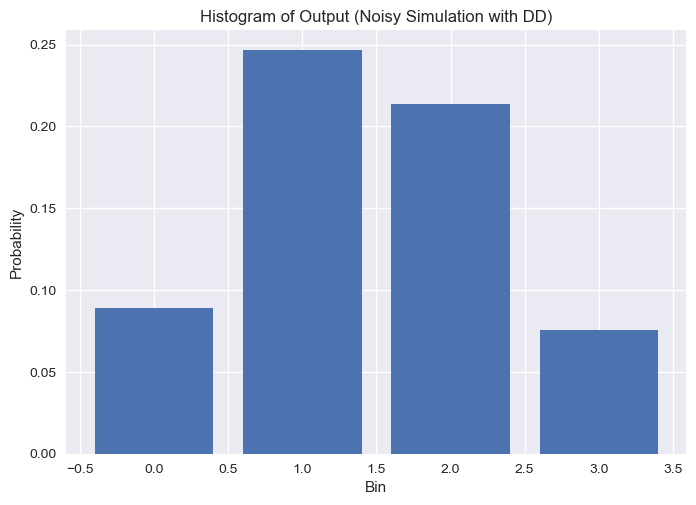

In [ ]:
#Define Circuit parameters
layers2 = 3
n_qubits = 7 + 1
n_bits = 4
bins2 = layers2 + 1
ancilla2 = 0
ball2 = layers2 + 1
state_0 = [1, 0]

pegdd_circuit = QuantumCircuit(n_qubits, n_bits)

# Setup
pegdd_circuit.h(ancilla2)
pegdd_circuit.x(ball2)

# First layer
pegdd_circuit.cswap(0, ball2 - 1, ball2)
pegdd_circuit.cx(ball2, 0)
pegdd_circuit.cswap(0, ball2, ball2 + 1)

# Second layer
pegdd_circuit.initialize(state_0, ancilla2)
pegdd_circuit.h(ancilla2)
for i in range(3):
    base2 = ball2 - 1 + i
    pegdd_circuit.cswap(0, base2 - 1, base2)
    pegdd_circuit.cx(base2, 0)
base2 += 1
pegdd_circuit.cswap(0, base2 - 1, base2)

# Third layer
pegdd_circuit.initialize(state_0, ancilla2)
pegdd_circuit.h(ancilla2)
for i in range(5):
    base2 = ball2 - 2 + i
    pegdd_circuit.cswap(ancilla2, base2 - 1, base2)
    pegdd_circuit.cx(base2, ancilla2)
base2 += 1
pegdd_circuit.cswap(0, base2 - 1, base2)

for i in range(bins):
    pegdd_circuit.measure((2 * i + 1), i)

QiskitRuntimeService.save_account(channel="ibm_quantum_platform", token="7N3mbyY33yxRsQ3uwQvs904tUcfY5hdM0R5wWlNRlgLB", overwrite=True)
servicedd = QiskitRuntimeService(channel="ibm_quantum_platform", instance="crn:v1:bluemix:public:quantum-computing:us-east:a/c7e62e1fb1fb4925b728838713b6aa25:6e4a7739-ec20-4abb-a8c4-f6632a04f502::")

backenddd = servicedd.backend('ibm_torino')

# Creating noise model from the backend properties
noise_modeldd = NoiseModel.from_backend(backenddd)

# Setting up noisy simulator
simulatordd = AerSimulator(noise_model=noise_modeldd)

# Get instruction durations from backend
durationsdd = InstructionDurations.from_backend(backenddd)

# Define DD sequence (XX sequence for dephasing suppression)
dd_sequencedd = [XGate(), XGate()]

# Transpile the circuit to basis gates and routing without scheduling
transpiled_no_dd = transpile(pegdd_circuit, backenddd, optimization_level=2, scheduling_method=None)

# Apply scheduling and dynamical decoupling
pmdd = PassManager([
    ALAPScheduleAnalysis(durationsdd),
    PadDynamicalDecoupling(durationsdd, dd_sequencedd)
])
transpiled_qcdd = pmdd.run(transpiled_no_dd)

# Running the simulation
shotsdd = 100000
resultdd = simulatordd.run(transpiled_qcdd, shots=shotsdd).result()
countsdd = resultdd.get_counts()

# Process counts to compute bin probabilities
bin2_probs2 = [0.0] * 4
error2_prob2 = 0.0

for state, count in countsdd.items():
    if state.count('1') == 1:  # Valid single-detection
        reversed_state2 = state[::-1]
        bin2_index = reversed_state2.index('1')
        bin2_probs2[bin2_index] += count / shotsdd
    else:
        error2_prob2 += count / shotsdd

print("Bin probabilities (bins 0 to 3):", bin2_probs2)
print("Error probability:", error2_prob2)
print("Sum of bin probabilities:", sum(bin2_probs2))
plt.bar(range(4), bin2_probs2)
plt.xlabel('Bin')
plt.ylabel('Probability')
plt.title('Histogram of Output (Noisy Simulation with DD)')
plt.show()

## 3.3 Error Suppression using Mitigation of readout error

<div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.1); font-family: Arial, sans-serif; color: #34495e; font-size: 16px; max-width: 100%; width: 100%; overflow-wrap: break-word; word-break: break-word; box-sizing: border-box">

  <h2 style="color: #2c3e50; font-size: 22px;"> Using Mitigation of Readout error</h2>
  <p> 
  This strategy involves, combining LocalReadoutError for targeted calibration and the implicit CompleteMitigator-like functionality (handling full state space), mitigating dominant readout errors in the quantum Galton board circuit, improving the reliability of bin distributions and error probabilities for analysis and visualization.

  <ol style="font-size: 14px;">

  <li> <b>Circuit Layout</b>: After setting up the circuit,we have incorporated noise properties from the IBM Torin backend via a NoiseModel.</li>

  <li> <b> Calibration and Error Mitigation</b> <br>
    Mitigating dominant readout errors in the quantum Galton board circuit, improving the reliability of bin distributions and error probabilities for analysis and visualization.  

   <ul style="font-size: 14px;">

  <li> <b> Calibration for Readout Errors</b>: Initializing a calibration experiment targeting specific measured qubits ([1, 3, 5, 7]), enabling the characterization of local readout errors (e.g., bit-flip misclassifications during measurement) on the noisy simulator backend. Shot count of 32,768 was used for - 
  
  <ul style="font-size: 14px;">

  <li> <b> Hardware and Simulator Constraints</b>: Many quantum backends and simulators, including those from IBM, are optimized for shot counts that are powers of 2 (e.g., 2<sup>15</sup> = 32,768). This alignment facilitates efficient memory allocation, parallel processing, and statistical sampling, as it corresponds to the binary nature of quantum state representations and hardware control systems. </li>

  <li> <b> Mitigation Precision</b>: Higher shot counts, allow for finer granularity in quasi-probability calculations and subsequent mitigation steps (nearest_probability_distribution), reducing variance in the error model and improving the mitigation’s effectiveness </li>
  
  </ul>
  </li>

  <li> <b> Experiment Execution and Mitigation</b>: Generating calibration data, which is used to create a "Local Readout Mitigator" (retrieved as mitigateddataddm), assuming independent errors per qubit for efficient correction without full correlation modeling</li>

  <li> <b>Application to simulation Results </b>: The mitigator applies quasi-probabilities to the raw counts and converts them to a nearest valid probability distribution, effectively reducing readout noise by reweighting outcomes to approximate error-free probabilities. </li>

  </ul>
  </li> 
  </li>
  </ol>
  </p> 
  </div>

Bin probabilities (bins 0 to 3): [0.10157599741189355, 0.31816010059933025, 0.27451562582061423, 0.0977531360637223]
Error probability: 0.2079951401044394
Sum of bin probabilities: 0.7920048598955602


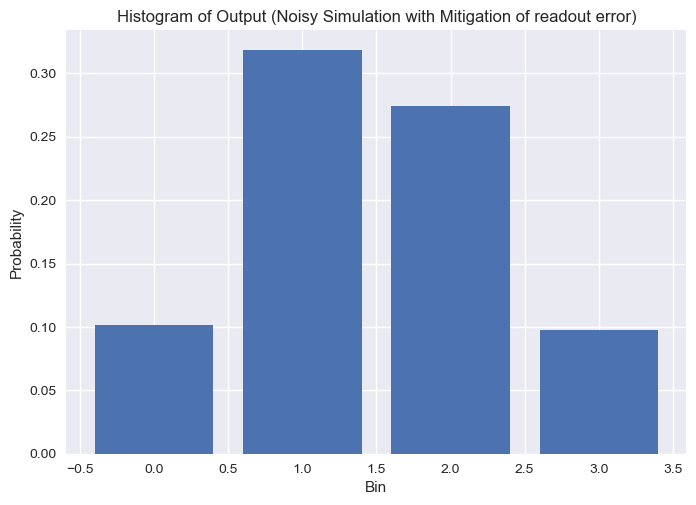

In [22]:
layers4 = 3
n_qubits = 7 + 1
n_bits = 4
bins4 = layers4 + 1
ancilla4 = 0
ball4 = layers4 + 1
state_0 = [1, 0]

pegm_circuit = QuantumCircuit(n_qubits, n_bits)

# Setup
pegm_circuit.h(ancilla4)
pegm_circuit.x(ball4)

# First layer
pegm_circuit.cswap(0, ball4 - 1, ball4)
pegm_circuit.cx(ball4, 0)
pegm_circuit.cswap(0, ball4, ball4 + 1)

# Second layer
pegm_circuit.initialize(state_0, ancilla4)
pegm_circuit.h(ancilla4)
for i in range(3):
    base4 = ball4 - 1 + i
    pegm_circuit.cswap(0, base4 - 1, base4)
    pegm_circuit.cx(base4, 0)
base4 += 1
pegm_circuit.cswap(0, base4 - 1, base4)

# Third layer
pegm_circuit.initialize(state_0, ancilla4)
pegm_circuit.h(ancilla4)
for i in range(5):
    base4 = ball4 - 2 + i
    pegm_circuit.cswap(ancilla4, base4 - 1, base4)
    pegm_circuit.cx(base4, ancilla4)
base4 += 1
pegm_circuit.cswap(0, base4 - 1, base4)


for i in range(bins4):
    pegm_circuit.measure((2 * i + 1), i)

QiskitRuntimeService.save_account(channel="ibm_quantum_platform",token="7N3mbyY33yxRsQ3uwQvs904tUcfY5hdM0R5wWlNRlgLB", overwrite=True)
servicem = QiskitRuntimeService(channel="ibm_quantum_platform", instance ="crn:v1:bluemix:public:quantum-computing:us-east:a/c7e62e1fb1fb4925b728838713b6aa25:6e4a7739-ec20-4abb-a8c4-f6632a04f502::")

backendm = servicem.backend('ibm_torino')

# Creating noise model from the backend properties (pulls live T1, T2, frequencies, gate errors, etc.)
noise_modelm = NoiseModel.from_backend(backendm)

# Setting up noisy simulator
simulatorm = AerSimulator(noise_model=noise_modelm)

# Transpile the circuit with optimization (level 3 for aggressive optimization)
transpiled_qcm = transpile(pegm_circuit, backend=backendm, optimization_level=2)

# Run calibration experiment on measured qubits [1,3,5,7]
measure_qubitsm = [1, 3, 5, 7]
expm = LocalReadoutError(measure_qubitsm)
exp_datam = expm.run(analysis=True, backend=simulatorm, shots=32768)
exp_datam.block_for_results()  # Wait for completion
mitigatorm = exp_datam.analysis_results("Local Readout Mitigator",dataframe=False).value

# Run the simulation
shotsm = 100000
resultm = simulatorm.run(transpiled_qcm, shots=shotsm).result()
countsm = resultm.get_counts()
mitigated_quasim = mitigatorm.quasi_probabilities(countsm)
mitigated_probsm = mitigated_quasim.nearest_probability_distribution().binary_probabilities()

# Process counts to compute bin probabilities
# Assuming ideal outcomes are one-hot on measured qubits (1,3,5,7) → bins 0-3; others as errors
bin4_probs4 = [(0.0)] * 4
error4_prob4 = 0.0
for state, prob in mitigated_probsm.items():
    bitstring = state[::-1]  # Adjust for bit order
    ones_count4 = bitstring.count('1')
    if ones_count4 == 1:
        bin4_index = bitstring.index('1')
        bin4_probs4[bin4_index] += float(prob)
    else:
        error4_prob4 += float(prob)

print("Bin probabilities (bins 0 to 3):", bin4_probs4)
print("Error probability:", error4_prob4)
print("Sum of bin probabilities:", sum(bin4_probs4))
plt.bar(range(4), bin4_probs4)
plt.xlabel('Bin')
plt.ylabel('Probability')
plt.title('Histogram of Output (Noisy Simulation with Mitigation of readout error)')
plt.show()

## 3.4 Error Suppression using DynamicalDecoupling & Mitigating readout error

<div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.1); font-family: Arial, sans-serif; color: #34495e; font-size: 16px; max-width: 100%; width: 100%; overflow-wrap: break-word; word-break: break-word; box-sizing: border-box">

  <h2 style="color: #2c3e50; font-size: 22px;">DynamicalDecoupling & Mitigating readout error</h2>

This strategy leverages dynamical decoupling to suppress dephasing errors and employs readout error mitigation to enhance accuracy, systematically quantifying and visualizing errors for performance evaluation. 

  <p>  
  </div>

Bin probabilities (bins 0 to 3): [0.09091372485352213, 0.26767172509787834, 0.22289647886211306, 0.07575257962189628]
Error probability: 0.3427654915645903
Sum of bin probabilities: 0.6572345084354099


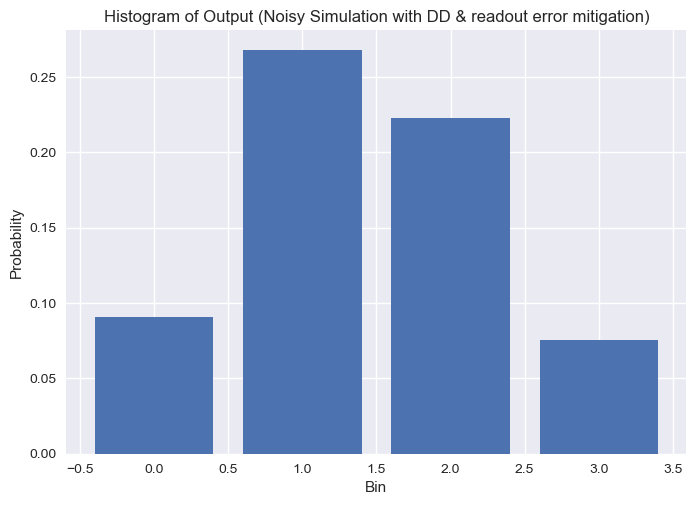

In [23]:
#Define Circuit parameters
layers3 = 3
n_qubits = 7 + 1
n_bits = 4
bins3 = layers3 + 1
ancilla3 = 0
ball3 = layers3 + 1
state_0 = [1, 0]

pegddm_circuit = QuantumCircuit(n_qubits, n_bits)

# Setup
pegddm_circuit.h(ancilla3)
pegddm_circuit.x(ball3)

# First layer
pegddm_circuit.cswap(0, ball3 - 1, ball3)
pegddm_circuit.cx(ball3, 0)
pegddm_circuit.cswap(0, ball3, ball3 + 1)

# Second layer
pegddm_circuit.initialize(state_0, ancilla3)
pegddm_circuit.h(ancilla3)
for i in range(3):
    base3 = ball3 - 1 + i
    pegddm_circuit.cswap(0, base3 - 1, base3)
    pegddm_circuit.cx(base3, 0)
base3 += 1
pegddm_circuit.cswap(0, base3 - 1, base3)

# Third layer
pegddm_circuit.initialize(state_0, ancilla3)
pegddm_circuit.h(ancilla3)
for i in range(5):
    base3 = ball3 - 2 + i
    pegddm_circuit.cswap(ancilla3, base3 - 1, base3)
    pegddm_circuit.cx(base3, ancilla3)
base3 += 1
pegddm_circuit.cswap(0, base3 - 1, base3)

for i in range(bins3):
    pegddm_circuit.measure((2 * i + 1), i)

QiskitRuntimeService.save_account(channel="ibm_quantum_platform", token="7N3mbyY33yxRsQ3uwQvs904tUcfY5hdM0R5wWlNRlgLB", overwrite=True)
serviceddm = QiskitRuntimeService(channel="ibm_quantum_platform", instance="crn:v1:bluemix:public:quantum-computing:us-east:a/c7e62e1fb1fb4925b728838713b6aa25:6e4a7739-ec20-4abb-a8c4-f6632a04f502::")

backendddm = serviceddm.backend('ibm_torino')

# Creating noise model from the backend properties
noise_modelddm = NoiseModel.from_backend(backendddm)

# Setting up noisy simulator
simulatorddm = AerSimulator(noise_model=noise_modelddm)

# Get instruction durations from backend
durationsddm = InstructionDurations.from_backend(backendddm)

# Define DD sequence (XX sequence for dephasing suppression)
dd_sequenceddm= [XGate(), XGate()]

# Transpile the circuit to basis gates and routing without scheduling
transpiled_no_ddm = transpile(pegddm_circuit, backendddm, optimization_level=2, scheduling_method=None)

# Apply scheduling and dynamical decoupling
pmddm = PassManager([
    ALAPScheduleAnalysis(durationsddm),
    PadDynamicalDecoupling(durationsddm, dd_sequenceddm)
])
transpiled_qcddm = pmddm.run(transpiled_no_ddm)

# Run calibration experiment on measured qubits [1,3,5,7]
measure_qubitsddm = [1, 3, 5, 7]
expddm = LocalReadoutError(measure_qubitsddm)
exp_dataddm = expddm.run(analysis=True, backend=simulatorddm, shots=32768)
exp_dataddm.block_for_results()  # Wait for completion
mitigatorddm = exp_dataddm.analysis_results("Local Readout Mitigator",dataframe = False).value

# Run the simulation
shotsddm = 100000
resultddm = simulatorddm.run(transpiled_qcddm, shots=shotsddm).result()
countsddm = resultddm.get_counts()
mitigated_quasiddm = mitigatorddm.quasi_probabilities(countsddm)
mitigated_probsddm = mitigated_quasiddm.nearest_probability_distribution().binary_probabilities()


# Process counts to compute bin probabilities
# Assuming ideal outcomes are one-hot on measured qubits (1,3,5,7) → bins 0-3; others as errors
bin3_probs3 = [0.0] * 4
error3_prob3 = 0.0
for state, prob in mitigated_probsddm.items():
    bitstring = state[::-1]  # Adjust for bit order
    ones_count3 = bitstring.count('1')
    if ones_count3 == 1:
        bin3_index = bitstring.index('1')
        bin3_probs3[bin3_index] += float(prob)
    else:
        error3_prob3 += float(prob)

print("Bin probabilities (bins 0 to 3):", bin3_probs3)
print("Error probability:", error3_prob3)
print("Sum of bin probabilities:", sum(bin3_probs3))
plt.bar(range(4), bin3_probs3)
plt.xlabel('Bin')
plt.ylabel('Probability')
plt.title('Histogram of Output (Noisy Simulation with DD & readout error mitigation)')
plt.show()

## 4 Conclusion

<div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.1); font-family: Arial, sans-serif; color: #34495e; font-size: 16px; max-width: 100%; width: 100%; overflow-wrap: break-word; word-break: break-word; box-sizing: border-box">

  <h2 style="color: #2c3e50; font-size: 22px;"> Conclusion </h2>
  <p>
  Our simulation shots are 100000 and for calibrating readout error we have simulated 32,768 times - we have kept this consistent over all the methods whereever needed.

  On real hardware, higher shots yield more precise expectation values and quasi-probabilities, enhancing techniques like dynamical decoupling (your XX sequence) and readout mitigation. For instance, 100,000 shots can suppress statistical noise below hardware error rates (<~10<sup>-3</sup> ), allowing clearer distinction between coherent errors and random fluctuations.

  Calibration with 32,768 shots refines the CompleteMitigator-like process, reducing bias in corrected distributions. This is crucial for hardware, where readout errors (1-5% per qubit) dominate; accurate calibration minimizes amplification of issues like crosstalk, potentially lowering your observed error probability on backends with variable noise. Increasing it further, didn't have a significant impact on the error probability.

  Overall, we got the following error probability (~ in the order):

  <ul style="font-size: 14px;">
   <li> <b> Noise Simulation</b> : 0.276</li>
   <li> <b> Noise Mitigation using DynamicalDecoupling</b> : 0.375</li>
   <li> <b> Noise Mitigation using Error readout mitigation</b> : 0.207</li>
   <li> <b> Noise Mitigation using DynamicalDecoupling & Error readout mitigation</b> :0.344</li>
   
   </ul>

   It is very evident, the simulation is better optimised when error readout mitigation is used.

  </p>  
  </div>